In [254]:
import os
import re
import nltk
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from io import BytesIO
import missingno as msno
import matplotlib as mpl
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from transformers import pipeline
from gensim.models import word2vec
from nltk.tokenize import word_tokenize

In [247]:
ACC_TOKEN = "<YOUR_TOKEN>"

In [65]:
tqdm.pandas()

In [2]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [3]:
plt.style.use("fast")

In [4]:
STOPWORDS_BAHASA = stopwords.words("indonesian") + [',', 'di', ":"]

In [5]:
os.listdir()

['.ipynb_checkpoints',
 'Category & Attribute - All Industries.xlsx',
 'inflasi.json',
 '[1] Dataset Preparation.ipynb']

In [6]:
data = pd.read_json('inflasi.json')

In [7]:
filter_data = data[['post_time', 'title', 'content', 'tags']]

filter_data.head()

,post_time,title,content,tags
0,8 Oktober 2022 06:30 WIB,"Kemarin, cadangan devisa turun hingga sorotan ...",Jakarta (ANTARA) - Sejumlah informasi penting ...,"[Cadangan devisa, IMF, BPJS, Biomassa, IHSG]"
1,8 Oktober 2022 06:16 WIB,"Wall Street ditutup anjlok, Indeks Dow Jones j...",Pasar menerima kabar baik dari laporan pasar t...,"[Wall Street, indeks dow jones, indeks s&p, in..."
2,8 Oktober 2022 05:50 WIB,Dolar menguat setelah laporan pekerjaan AS leb...,Setiap tanda kelemahan ekonomi AS akan sangat ...,"[kurs dolar, indeks dolar, data pekerjaan amer..."
3,8 Oktober 2022 05:38 WIB,"Harga minyak naik 4 persen, terkerek pemotonga...",Di antara konsekuensi utama dari pemotongan te...,"[harga minyak, minyak berjangka, minyak Brent,..."
4,7 Oktober 2022 21:31 WIB,BI dorong kerja sama antardaerah tingkatkan ke...,"Semisal, Sumsel menyediakan lahan, nanti untuk...","[Bank Indonesia, BI, BI Sumsel, pangan, ketaha..."


# 1. Data Visualisation

## 1.0 Missing Values

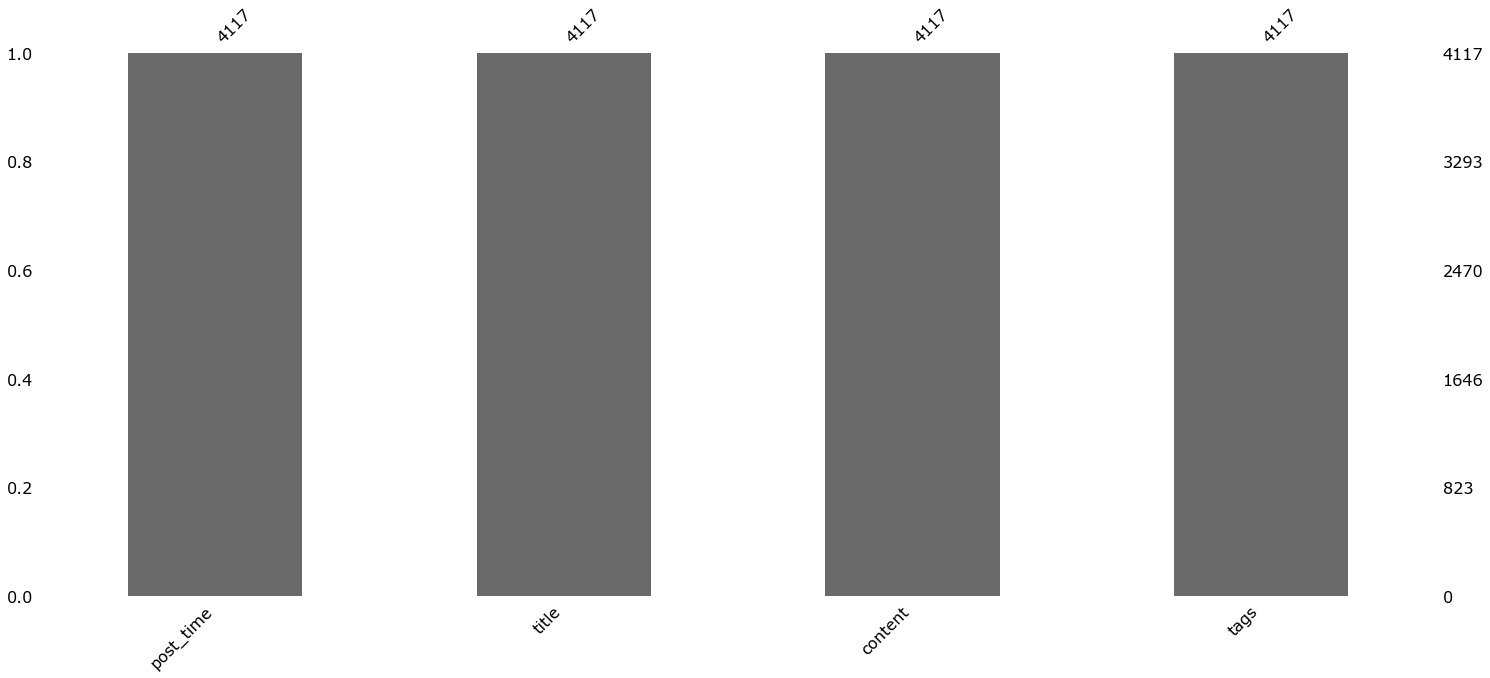

In [8]:
filter_data = filter_data.dropna()

msno.bar(filter_data);

## 1.1. Post Time Series

In [9]:
ORDER_MONTH = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus", "September", "Oktober"]

In [10]:
# extract time data
post_time = filter_data['post_time']
post_time = post_time.str.split(" ", expand = True)
post_time.columns = [['tanggal', 'bulan', 'tahun', 'jam', 'satuan waktu']]

post_time.head()

,tanggal,bulan,tahun,jam,satuan waktu
0,8,Oktober,2022,06:30,WIB
1,8,Oktober,2022,06:16,WIB
2,8,Oktober,2022,05:50,WIB
3,8,Oktober,2022,05:38,WIB
4,7,Oktober,2022,21:31,WIB


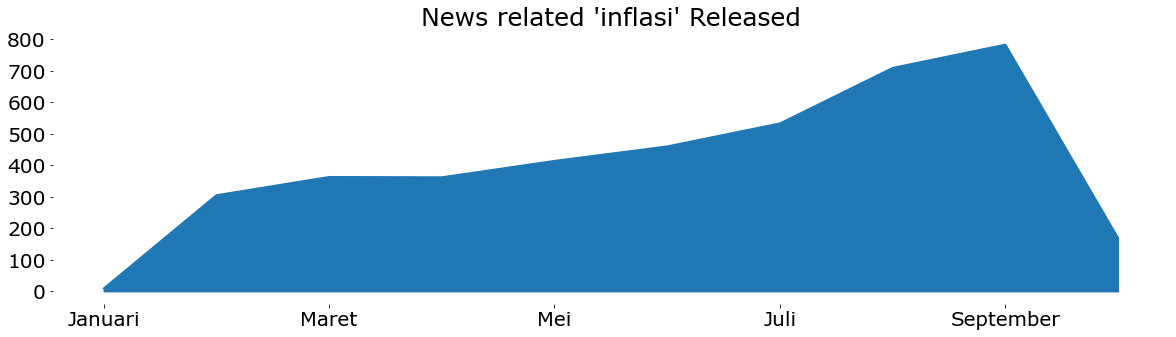

In [11]:
post_time['bulan'].iloc[:, 0].value_counts().reindex(ORDER_MONTH, axis = 0).plot(kind = "area", figsize = (20, 5), fontsize = 20).set_title("News related 'inflasi' Released", fontsize = 25);

## 1.2. Title Wordcloud

In [12]:
filter_data['title'].head()

0    Kemarin, cadangan devisa turun hingga sorotan ...
1    Wall Street ditutup anjlok, Indeks Dow Jones j...
2    Dolar menguat setelah laporan pekerjaan AS leb...
3    Harga minyak naik 4 persen, terkerek pemotonga...
4    BI dorong kerja sama antardaerah tingkatkan ke...
Name: title, dtype: object

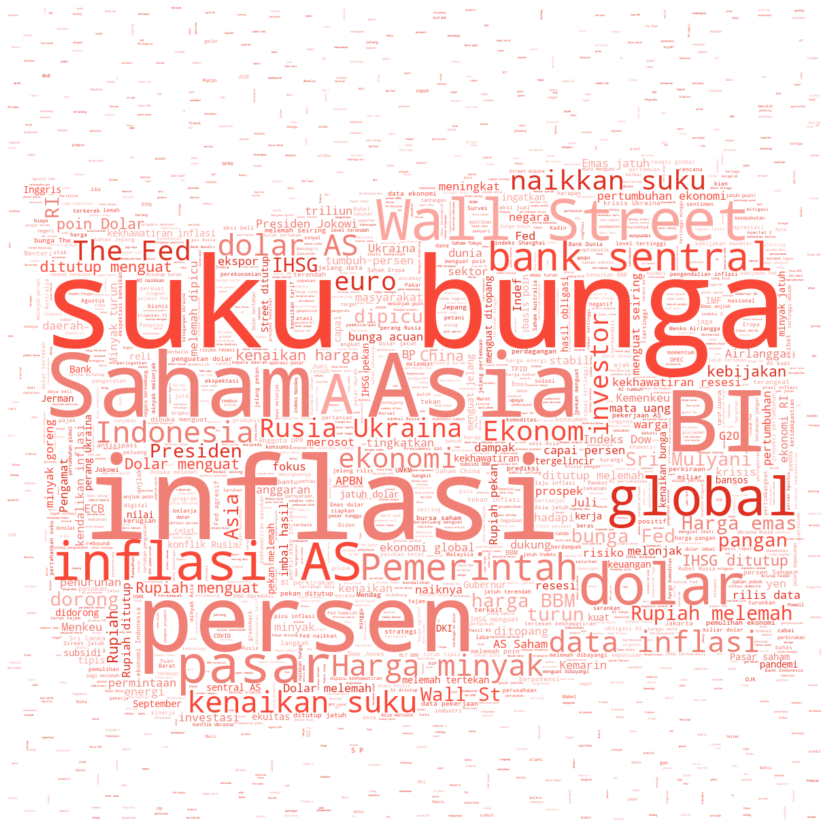

In [13]:
TITLE = filter_data['title'].apply(lambda x: " ".join([word for word in x.split() if not word in STOPWORDS_BAHASA]))

url = "https://png.pngtree.com/png-clipart/20220704/original/pngtree-bendera-merah-putih-indonesia-png-image_8295803.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    colors = [[5, 80, 70],
              [5, 75, 50],
              [5, 95, 60],
              [5, 90, 80]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

                                      
mask = np.array(img)
wc = WordCloud(stopwords = STOPWORDS_BAHASA,
               mask = mask, background_color = "white",
               max_words = 2000, max_font_size = 256,
               random_state = 42, width = mask.shape[1],
               height = mask.shape[0], color_func = similar_color_func)
wc.generate(" ".join(TITLE.tolist()))
plt.figure(figsize = (20, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## 1.3. Content Viz.

In [14]:
filter_data['content'].head()

0    Jakarta (ANTARA) - Sejumlah informasi penting ...
1    Pasar menerima kabar baik dari laporan pasar t...
2    Setiap tanda kelemahan ekonomi AS akan sangat ...
3    Di antara konsekuensi utama dari pemotongan te...
4    Semisal, Sumsel menyediakan lahan, nanti untuk...
Name: content, dtype: object

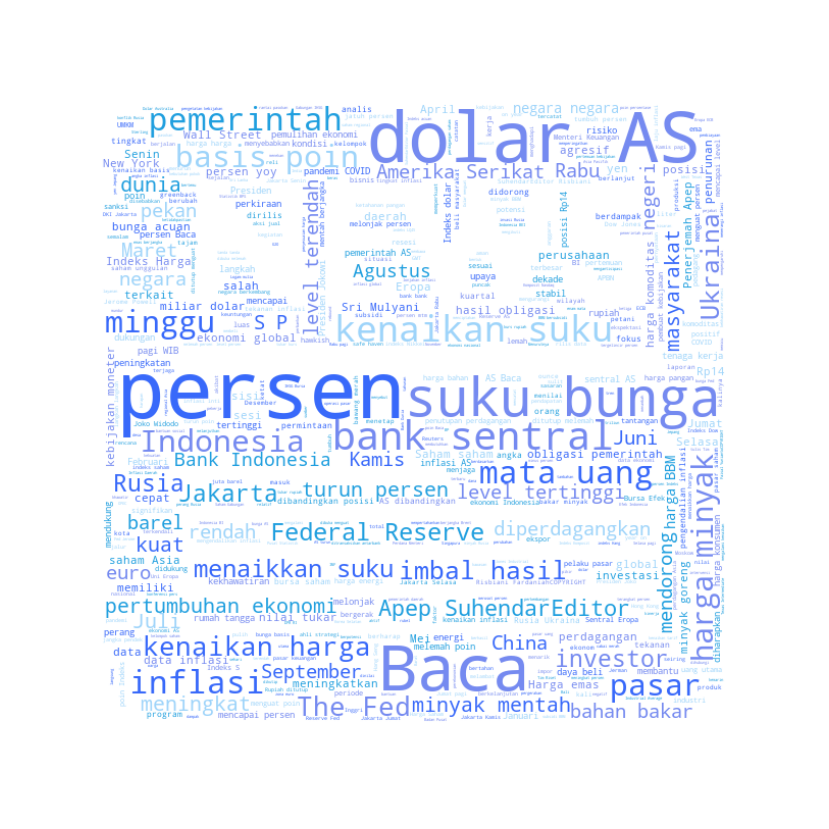

In [15]:
CONTENT = filter_data['content']# .apply(lambda x: " ".join([word for word in x.split() if not word in STOPWORDS_BAHASA]))

url = "https://d2gg9evh47fn9z.cloudfront.net/800px_COLOURBOX26412740.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    colors = [[230, 80, 70],
              [200, 75, 50],
              [225, 95, 60],
              [205, 90, 80]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

                                      
mask = np.array(img)
wc = WordCloud(stopwords = STOPWORDS_BAHASA,
               mask = mask, background_color = "white",
               max_words = 2000, max_font_size = 256,
               random_state = 42, width = mask.shape[1],
               height = mask.shape[0], color_func = similar_color_func)
wc.generate(" ".join(CONTENT.tolist()))
plt.figure(figsize = (20, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## 1.4. Tags Viz.

In [16]:
filter_data["tags"].head()

0         [Cadangan devisa, IMF, BPJS, Biomassa, IHSG]
1    [Wall Street, indeks dow jones, indeks s&p, in...
2    [kurs dolar, indeks dolar, data pekerjaan amer...
3    [harga minyak, minyak berjangka, minyak Brent,...
4    [Bank Indonesia, BI, BI Sumsel, pangan, ketaha...
Name: tags, dtype: object

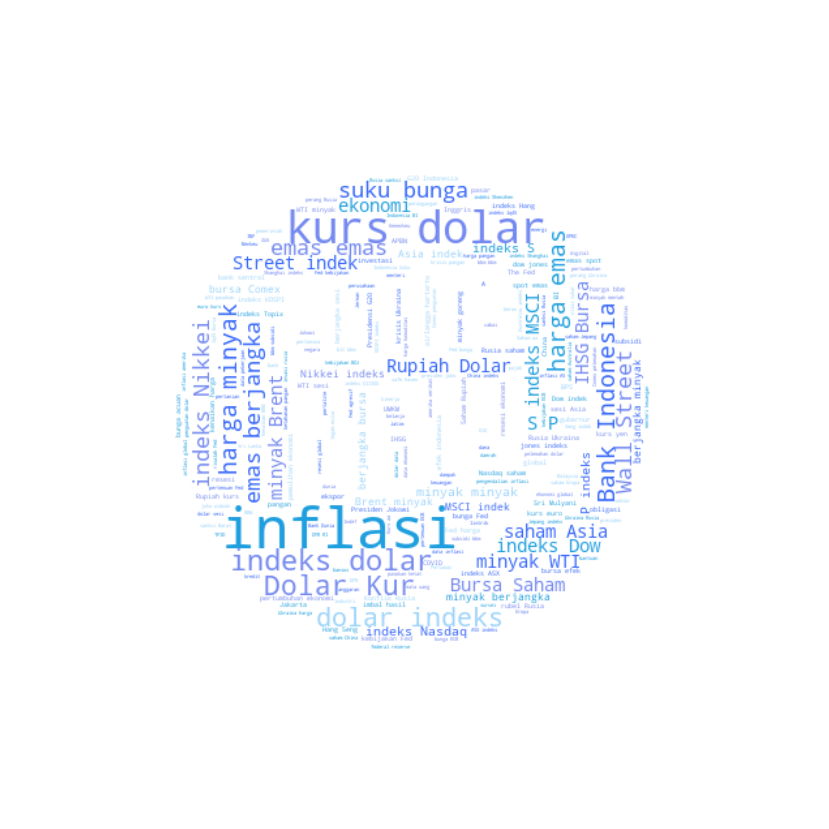

In [17]:
TAGS = filter_data["tags"] # .apply(lambda x: " ".join([word for word in x.split() if not word in STOPWORDS_BAHASA]))

url = "https://img.freepik.com/premium-vector/red-book-now-label-modern-style-white-background_123447-428.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    colors = [[230, 80, 70],
              [200, 75, 50],
              [225, 95, 60],
              [205, 90, 80]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

                                      
mask = np.array(img)
wc = WordCloud(stopwords = STOPWORDS_BAHASA,
               mask = mask, background_color = "white",
               max_words = 2000, max_font_size = 256,
               random_state = 42, width = mask.shape[1],
               height = mask.shape[0], color_func = similar_color_func)
wc.generate(" ".join(TAGS.apply(lambda x: " ".join(x)).tolist()))
plt.figure(figsize = (20, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

# 2. Data Kategorisasi (Labeling)

## 2.1. Text Cleaning (simple)

In [26]:
CLEAN_PATTERN_RE = r'[-\(\)\"#\/@;:<>\{\}\-=~|\\?\n\r]'

In [18]:
filter_data.head()

,post_time,title,content,tags
0,8 Oktober 2022 06:30 WIB,"Kemarin, cadangan devisa turun hingga sorotan ...",Jakarta (ANTARA) - Sejumlah informasi penting ...,"[Cadangan devisa, IMF, BPJS, Biomassa, IHSG]"
1,8 Oktober 2022 06:16 WIB,"Wall Street ditutup anjlok, Indeks Dow Jones j...",Pasar menerima kabar baik dari laporan pasar t...,"[Wall Street, indeks dow jones, indeks s&p, in..."
2,8 Oktober 2022 05:50 WIB,Dolar menguat setelah laporan pekerjaan AS leb...,Setiap tanda kelemahan ekonomi AS akan sangat ...,"[kurs dolar, indeks dolar, data pekerjaan amer..."
3,8 Oktober 2022 05:38 WIB,"Harga minyak naik 4 persen, terkerek pemotonga...",Di antara konsekuensi utama dari pemotongan te...,"[harga minyak, minyak berjangka, minyak Brent,..."
4,7 Oktober 2022 21:31 WIB,BI dorong kerja sama antardaerah tingkatkan ke...,"Semisal, Sumsel menyediakan lahan, nanti untuk...","[Bank Indonesia, BI, BI Sumsel, pangan, ketaha..."


In [29]:
# downsampling dataset 
raw_data = filter_data[['title', 'content']]
raw_data.head()

,title,content
0,"Kemarin, cadangan devisa turun hingga sorotan ...",Jakarta (ANTARA) - Sejumlah informasi penting ...
1,"Wall Street ditutup anjlok, Indeks Dow Jones j...",Pasar menerima kabar baik dari laporan pasar t...
2,Dolar menguat setelah laporan pekerjaan AS leb...,Setiap tanda kelemahan ekonomi AS akan sangat ...
3,"Harga minyak naik 4 persen, terkerek pemotonga...",Di antara konsekuensi utama dari pemotongan te...
4,BI dorong kerja sama antardaerah tingkatkan ke...,"Semisal, Sumsel menyediakan lahan, nanti untuk..."


In [33]:
raw_data['cleaned_content'] = raw_data['content'].apply(lambda x: re.sub(CLEAN_PATTERN_RE, "", x))
raw_data['cleaned_title']   = raw_data['title'].apply(lambda x: re.sub(CLEAN_PATTERN_RE, "", x))
raw_data.head()

,title,content,cleaned_content,cleaned_title
0,"Kemarin, cadangan devisa turun hingga sorotan ...",Jakarta (ANTARA) - Sejumlah informasi penting ...,Jakarta ANTARA Sejumlah informasi penting men...,"Kemarin, cadangan devisa turun hingga sorotan ..."
1,"Wall Street ditutup anjlok, Indeks Dow Jones j...",Pasar menerima kabar baik dari laporan pasar t...,Pasar menerima kabar baik dari laporan pasar t...,"Wall Street ditutup anjlok, Indeks Dow Jones j..."
2,Dolar menguat setelah laporan pekerjaan AS leb...,Setiap tanda kelemahan ekonomi AS akan sangat ...,Setiap tanda kelemahan ekonomi AS akan sangat ...,Dolar menguat setelah laporan pekerjaan AS leb...
3,"Harga minyak naik 4 persen, terkerek pemotonga...",Di antara konsekuensi utama dari pemotongan te...,Di antara konsekuensi utama dari pemotongan te...,"Harga minyak naik 4 persen, terkerek pemotonga..."
4,BI dorong kerja sama antardaerah tingkatkan ke...,"Semisal, Sumsel menyediakan lahan, nanti untuk...","Semisal, Sumsel menyediakan lahan, nanti untuk...",BI dorong kerja sama antardaerah tingkatkan ke...


In [55]:
# extract each "sentence" on news based on dot (.) and comma (,).
# we apply several filterization to reduce probability of out of polarity
extracted_data = []
for sentence in tqdm(raw_data['cleaned_content'], desc = "extract dataset"):
    for sentence_dot in sentence.split("."):
        if "," in sentence_dot:
            for sentence_comma in sentence_dot.split(","):
                if len(sentence_comma.split()) > 5:
                    extracted_data.append(sentence_comma.strip())
        else:
            if len(sentence_dot.split()) > 5:
                extracted_data.append(sentence_dot.strip())

extract dataset: 100%|██████████████████████████████████████████████████████████| 4117/4117 [00:00<00:00, 26276.99it/s]


In [98]:
data_extract = pd.DataFrame({"sentence" : extracted_data})

## 2.2. Content Labeling using Pre-defined category

In [59]:
# read pre-defined category dataset
bank_cat = pd.read_excel("Category & Attribute - All Industries.xlsx", sheet_name = "Banking")
pang_cat = pd.read_excel("Category & Attribute - All Industries.xlsx", sheet_name = "FnB")
gove_cat = pd.read_excel("Category & Attribute - All Industries.xlsx", sheet_name = "Government")

In [233]:
def generate_vector_visualisation(CORPUS, THRESHOLD = 50):
    """
    Function to generate vector embedding correlation between several text as graph based representation.
    """
    
    #Fitting word2vec model with tokenized corpus of sentence
    model = word2vec.Word2Vec(CORPUS, vector_size = 100, window = 20, min_count = 4, workers = 8)
    
    #Define index and vectorized sentence of word2vec
    index_wv = list(model.wv.key_to_index)
    X = model.wv[index_wv]
    
    #Generate dataframe to define correlation
    vector = pd.DataFrame(X)
    vector['word'] = index_wv
    vector.set_index("word", inplace = True)
    
    #Computing the correlation matrix
    X_corr = vec_bank.corr()

    #Computing eigen values and eigen vectors
    values, vectors = np.linalg.eig(X_corr)

    #Sorting the eigen vectors coresponding to eigen values in descending order
    args = (-values).argsort()
    values = vectors[args]
    vectors = vectors[:, args]

    #Taking first 2 components which explain maximum variance for projecting
    new_vectors = vectors[:,:2]

    #Projecting it onto new dimesion with 2 axis
    neww_X = np.dot(X,new_vectors)
    
    #Visualize word embedding based on threshold index
    plt.figure(figsize=(20, 10))
    plt.scatter(neww_X[:,0][:THRESHOLD], neww_X[:,1][:THRESHOLD], linewidths = 2, color = 'blue')
    plt.xlabel("PC1", size = 15)
    plt.ylabel("PC2", size = 15)
    plt.title("Word Embedding Space",size = 20)
    vocab = index_wv
    for i, word in enumerate(vocab[:THRESHOLD]):
        plt.annotate(word , xy = (neww_X[i, 0], neww_X[i, 1]), size = 15)
        
    plt.vlines(0, ymin = -10, ymax = 10, linewidth = 1, color = "red")  
    plt.hlines(0, xmin = -10, xmax = 10, linewidth = 1, color = "red")  
    plt.show()

### 2.2.1 Bank Aspect

In [66]:
# check if pre=defined satisfied enough with our 'inflasi' dataset.
data_extract['sentence'].progress_apply(lambda x: [word for word in x.split() if word in bank_cat['attr_noun'].tolist()].__len__())

100%|████████████████████████████████████████████████████████████████████████| 105596/105596 [01:42<00:00, 1035.11it/s]


0         2
1         1
2         0
3         1
4         0
         ..
105591    0
105592    3
105593    1
105594    2
105595    4
Name: sentence, Length: 105596, dtype: int64

In [92]:
category_bank = []
attr_bank = []
full_sentence = []
ATTRIBUT_BANK = bank_cat['attr_noun'].tolist()

for sentence in tqdm(extracted_data, desc = "labeling"):
    for word in sentence.split():
        if word in ATTRIBUT_BANK:
            category = bank_cat[bank_cat['attr_noun'] == word]['category'].tolist()[0]
            attr_bank.append(word)
            category_bank.append(category)
            full_sentence.append(sentence)

labeling: 100%|██████████████████████████████████████████████████████████████| 105596/105596 [01:22<00:00, 1282.89it/s]


In [93]:
category_bank.__len__(), attr_bank.__len__(), full_sentence.__len__()

(107415, 107415, 107415)

In [96]:
# wrap as dataframe
final_data_bank = pd.DataFrame({
    "sentence" : full_sentence,
    "attribute": attr_bank, 
    "aspect"   : category_bank
})

In [97]:
final_data_bank.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
1,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
2,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy
3,8 miliar dolar ASBank Indonesia BI mencatat po...,BI,Institutions
4,pasar tunggu rilis data pekerja ASIndeks Harga...,rilis,Launch


In [109]:
# save checkpoint of progress.
# final_data_bank.to_excel("ABSA_data_bank.xlsx", index = False)

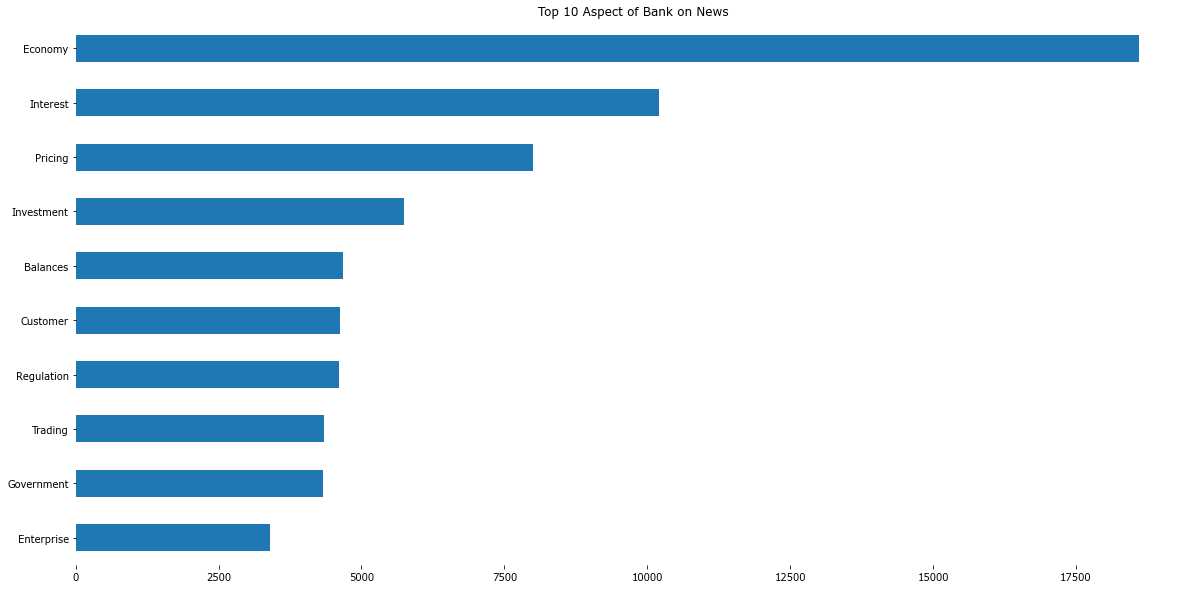

In [124]:
final_data_bank['aspect'].value_counts()[:10].sort_values().plot(kind = "barh", figsize = (20, 10)).set_title("Top 10 Aspect of Bank on News");

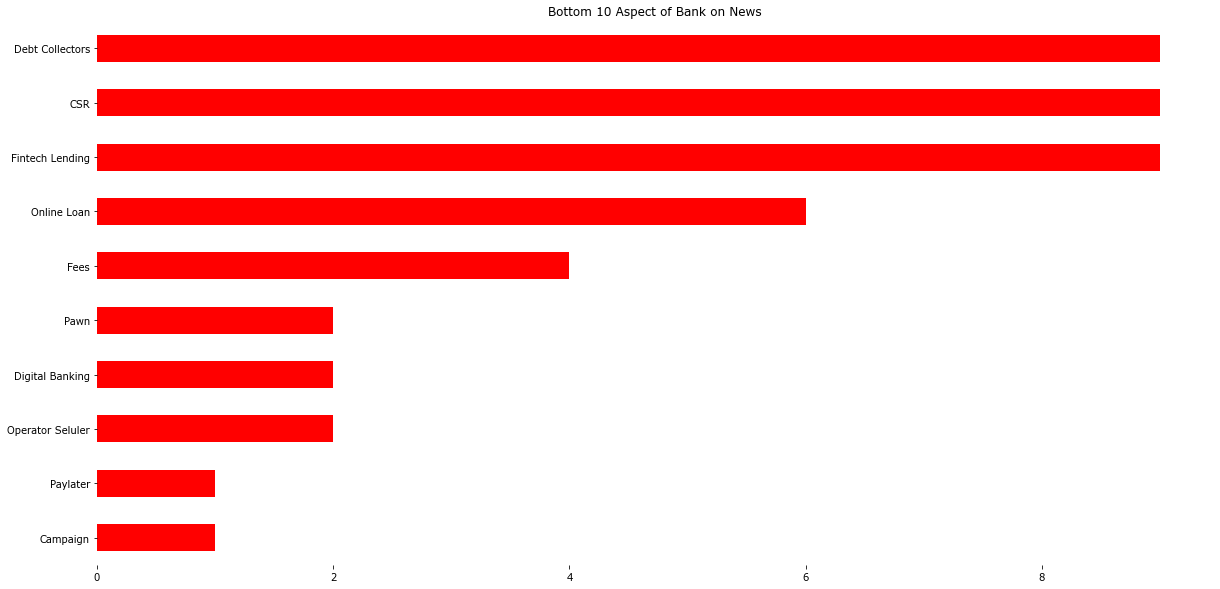

In [140]:
final_data_bank['aspect'].value_counts()[88:].sort_values().plot(kind = "barh", color = "red", figsize = (20, 10)).set_title("Bottom 10 Aspect of Bank on News");

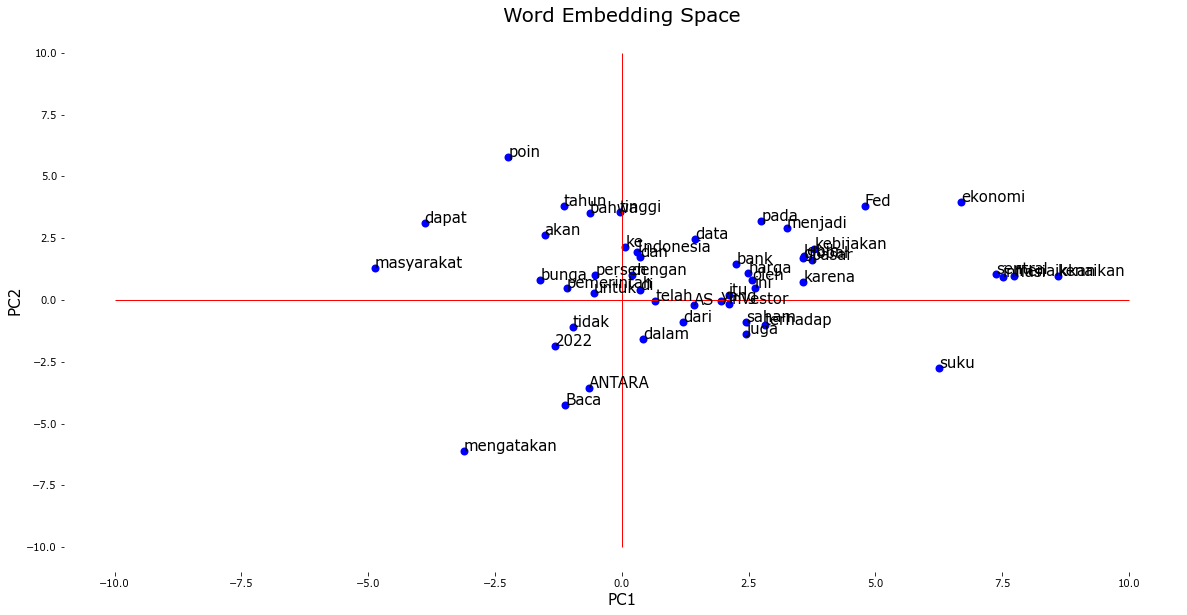

In [234]:
CORPUS_BANK = [sentence.split() for sentence in final_data_bank['sentence']]
generate_vector_visualisation(CORPUS_BANK)

### 2.2.2 Food n Beverage Aspect

In [99]:
# check if pre=defined satisfied enough with our 'inflasi' dataset.
data_extract['sentence'].progress_apply(lambda x: [word for word in x.split() if word in pang_cat['attr_noun'].tolist()].__len__())

100%|████████████████████████████████████████████████████████████████████████| 105596/105596 [01:35<00:00, 1109.82it/s]


0         3
1         2
2         0
3         3
4         0
         ..
105591    1
105592    3
105593    0
105594    3
105595    4
Name: sentence, Length: 105596, dtype: int64

In [100]:
category_pang = []
attr_pang = []
full_sentence = []
ATTRIBUT_PANG = pang_cat['attr_noun'].tolist()

for sentence in tqdm(extracted_data, desc = "labeling"):
    for word in sentence.split():
        if word in ATTRIBUT_PANG:
            category = pang_cat[pang_cat['attr_noun'] == word]['category'].tolist()[0]
            attr_pang.append(word)
            category_pang.append(category)
            full_sentence.append(sentence)

labeling: 100%|███████████████████████████████████████████████████████████████| 105596/105596 [01:59<00:00, 882.28it/s]


In [101]:
category_pang.__len__(), attr_pang.__len__(), full_sentence.__len__()

(136919, 136919, 136919)

In [102]:
# wrap as dataframe
final_data_pang = pd.DataFrame({
    "sentence" : full_sentence,
    "attribute": attr_pang, 
    "aspect"   : category_pang
})

In [103]:
final_data_pang.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,Jakarta,Location
1,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
2,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
3,mulai dari turunnya cadangan devisa Indonesia ...,Indonesia,Location
4,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy


In [110]:
# save checkpoint of progress.
# final_data_pang.to_excel("ABSA_data_pangan.xlsx", index = False)

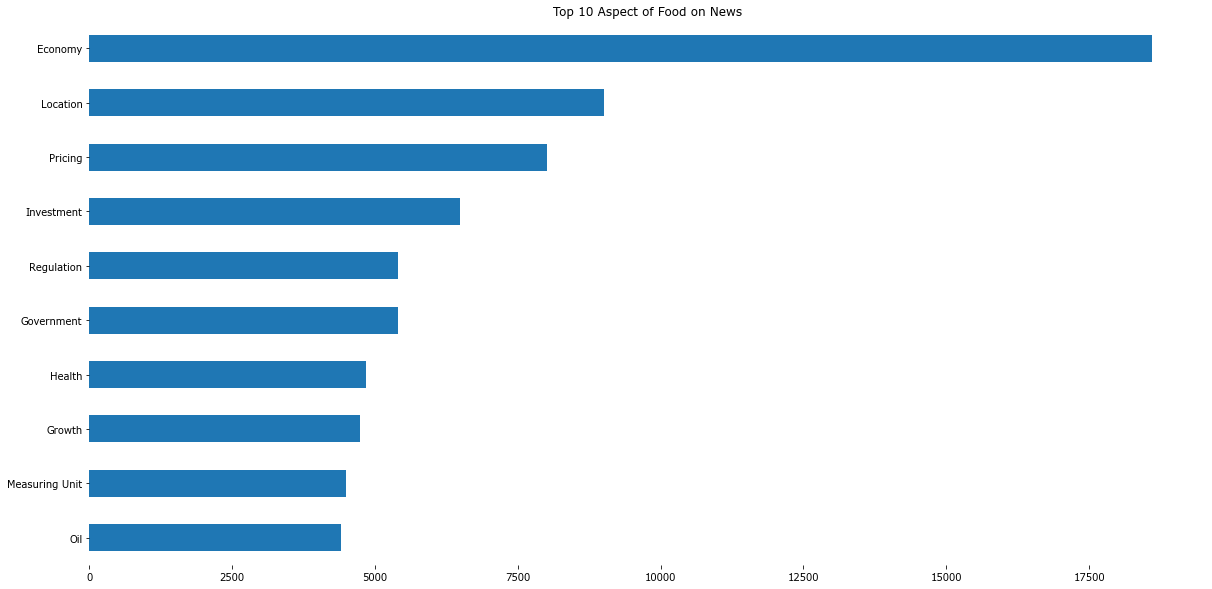

In [125]:
final_data_pang['aspect'].value_counts()[:10].sort_values().plot(kind = "barh", figsize = (20, 10)).set_title("Top 10 Aspect of Food on News");

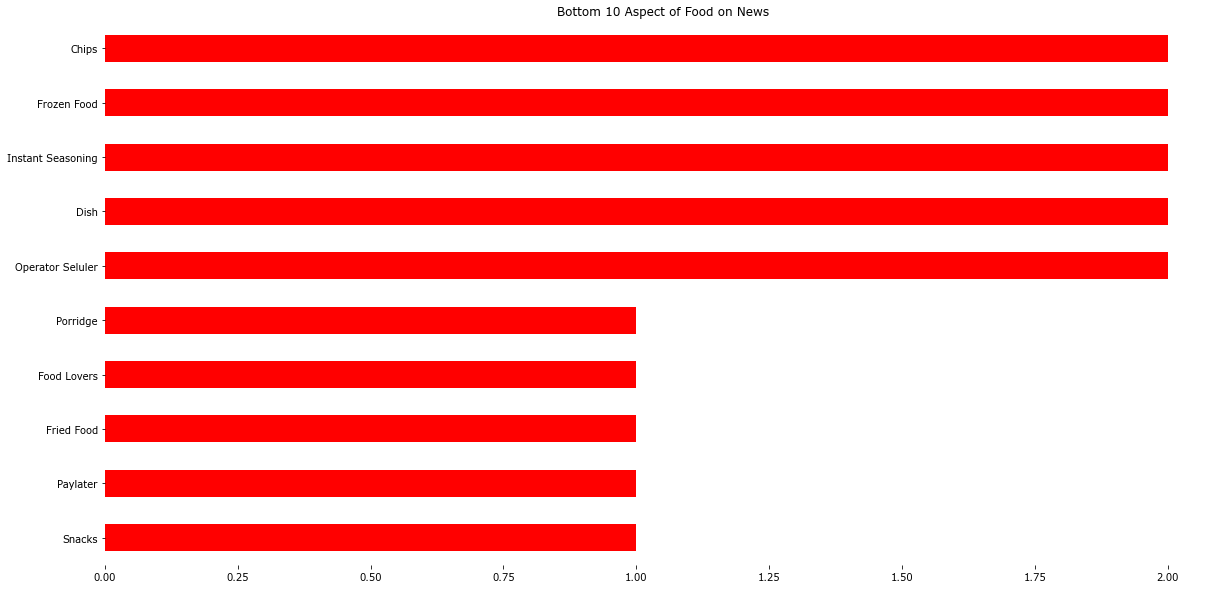

In [136]:
final_data_pang['aspect'].value_counts()[132:].sort_values().plot(kind = "barh", color = "red", figsize = (20, 10)).set_title("Bottom 10 Aspect of Food on News");

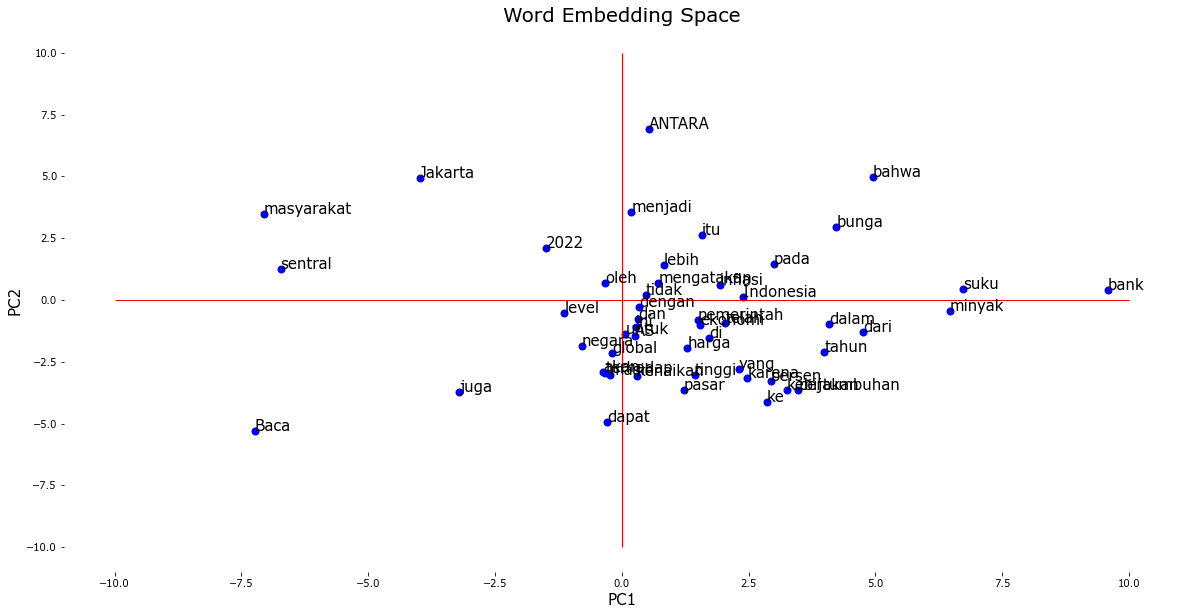

In [235]:
CORPUS_PANG = [sentence.split() for sentence in final_data_pang['sentence']]
generate_vector_visualisation(CORPUS_PANG)

### 2.2.3 Goverment Aspect

In [104]:
# check if pre=defined satisfied enough with our 'inflasi' dataset.
data_extract['sentence'].progress_apply(lambda x: [word for word in x.split() if word in gove_cat['attr_noun'].tolist()].__len__())

100%|████████████████████████████████████████████████████████████████████████| 105596/105596 [01:02<00:00, 1678.21it/s]


0         2
1         1
2         0
3         1
4         0
         ..
105591    0
105592    2
105593    1
105594    2
105595    3
Name: sentence, Length: 105596, dtype: int64

In [105]:
category_gove = []
attr_gove = []
full_sentence = []
ATTRIBUT_GOVE = gove_cat['attr_noun'].tolist()

for sentence in tqdm(extracted_data, desc = "labeling"):
    for word in sentence.split():
        if word in ATTRIBUT_GOVE:
            category = gove_cat[gove_cat['attr_noun'] == word]['category'].tolist()[0]
            attr_gove.append(word)
            category_gove.append(category)
            full_sentence.append(sentence)

labeling: 100%|██████████████████████████████████████████████████████████████| 105596/105596 [01:07<00:00, 1561.85it/s]


In [106]:
category_gove.__len__(), attr_gove.__len__(), full_sentence.__len__()

(86175, 86175, 86175)

In [107]:
# wrap as dataframe
final_data_gove = pd.DataFrame({
    "sentence" : full_sentence,
    "attribute": attr_gove, 
    "aspect"   : category_gove
})

In [108]:
final_data_gove.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
1,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
2,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy
3,8 miliar dolar ASBank Indonesia BI mencatat po...,BI,Banking
4,pasar tunggu rilis data pekerja ASIndeks Harga...,rilis,Launch


In [111]:
# save checkpoint of progress.
# final_data_gove.to_excel("ABSA_data_pemerintah.xlsx", index = False)

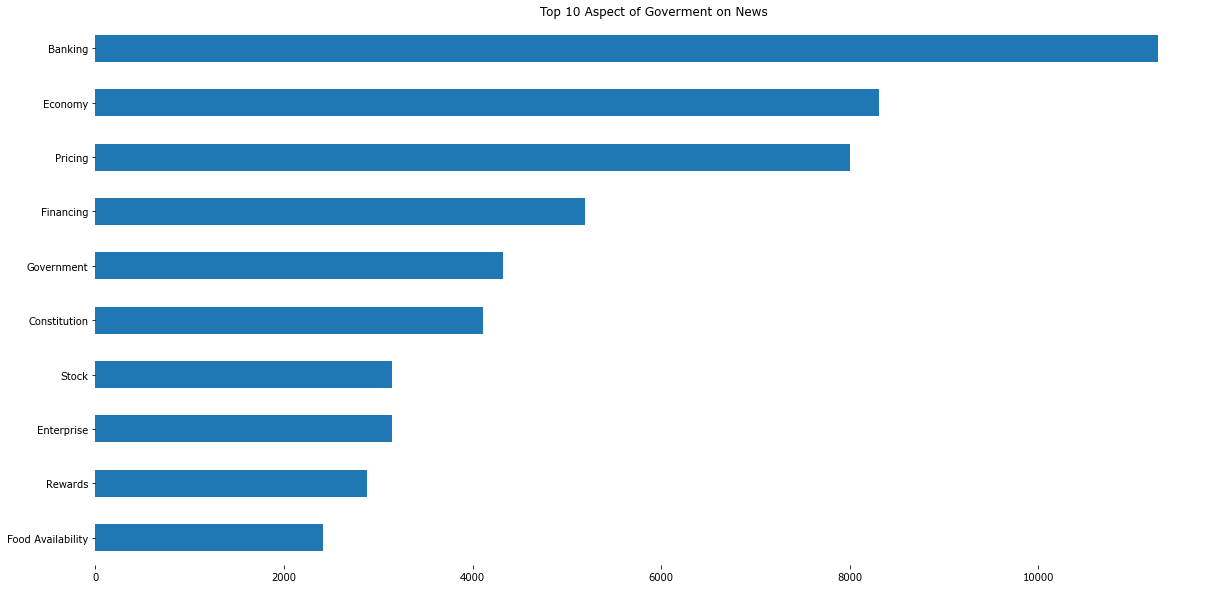

In [126]:
final_data_gove['aspect'].value_counts()[:10].sort_values().plot(kind = "barh", figsize = (20, 10)).set_title("Top 10 Aspect of Goverment on News");

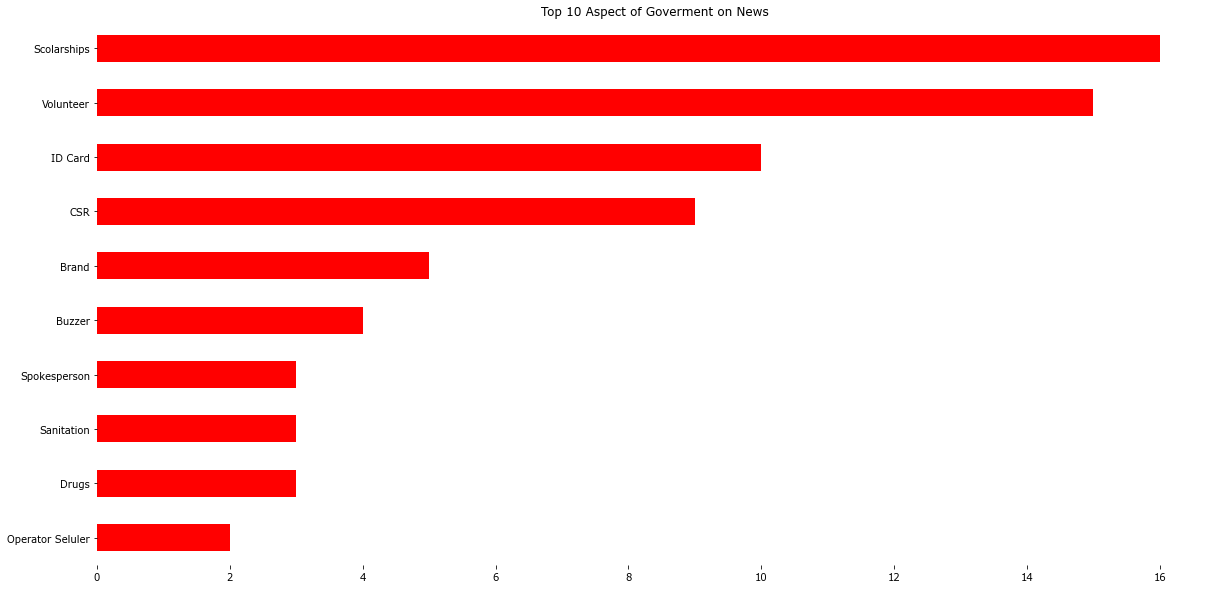

In [135]:
final_data_gove['aspect'].value_counts()[94:].sort_values().plot(kind = "barh", color = "red", figsize = (20, 10)).set_title("Top 10 Aspect of Goverment on News");

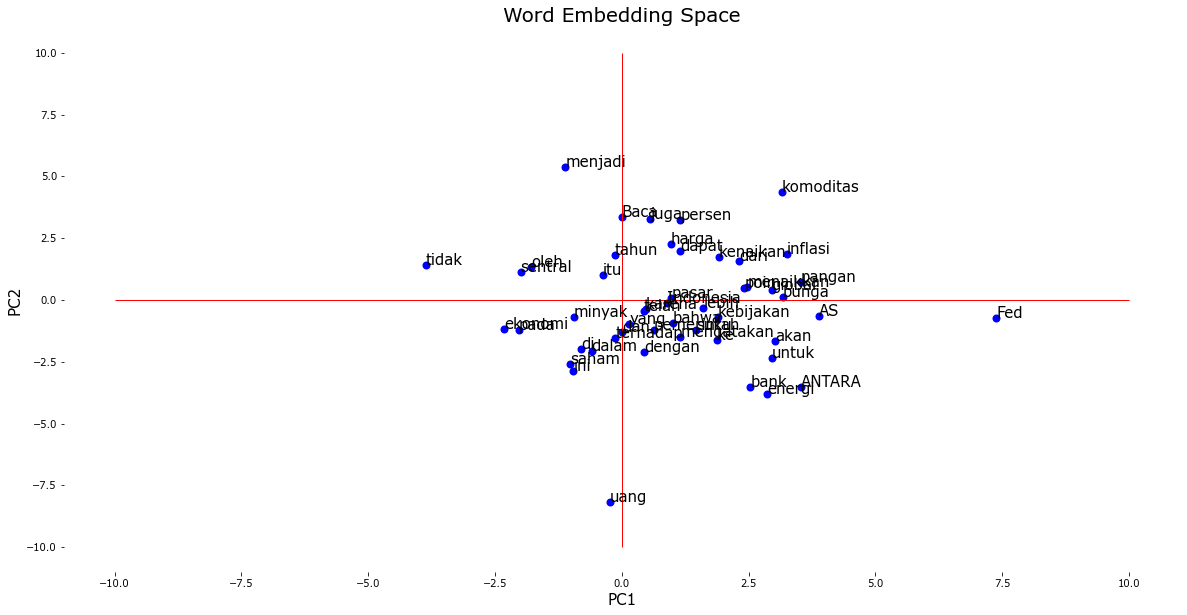

In [236]:
CORPUS_GOVE = [sentence.split() for sentence in final_data_gove['sentence']]
generate_vector_visualisation(CORPUS_GOVE)

## 2.3. Sentiment Labeling using IndoNLU Pretrained Model (RoBerta)

source: [here](https://huggingface.co/sahri/indonesiasentiment)

In [272]:
PRETRAINED_NAME = "sahri/indonesiasentiment"
SENTIMENT_LABELING = pipeline(
    "sentiment-analysis",  
    model = pretrained_name,
    tokenizer = pretrained_name, 
    use_auth_token = ACC_TOKEN,
    device = "cuda:0"
)

### 2.3.1 Data Banking

In [264]:
final_data_bank.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
1,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
2,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy
3,8 miliar dolar ASBank Indonesia BI mencatat po...,BI,Institutions
4,pasar tunggu rilis data pekerja ASIndeks Harga...,rilis,Launch


In [273]:
label, score = [], []
for sentence in tqdm(final_data_bank['sentence'], desc = "Labeling..."):
    result = SENTIMENT_LABELING(sentence)[0]
    label.append(result['label'])
    score.append(result['score'])
    
final_data_bank["score"] = score
final_data_bank["label"] = label

Labeling...:   0%|                                                               | 4/107415 [00:05<31:58:37,  1.07s/it]C:\Users\alif\anaconda3\envs\test\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Labeling...: 100%|████████████████████████████████████████████████████████████| 107415/107415 [15:40<00:00, 114.24it/s]


In [274]:
final_data_bank.head()

,sentence,attribute,aspect,score,label
0,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education,0.998727,neutral
1,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy,0.998727,neutral
2,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy,0.990104,neutral
3,8 miliar dolar ASBank Indonesia BI mencatat po...,BI,Institutions,0.994959,neutral
4,pasar tunggu rilis data pekerja ASIndeks Harga...,rilis,Launch,0.995949,neutral


In [276]:
final_data_bank.to_excel("ABSA_data_bank_label.xlsx", index = False)

### 2.3.2 Data Food and Beverage

In [277]:
final_data_pang.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,Jakarta,Location
1,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
2,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
3,mulai dari turunnya cadangan devisa Indonesia ...,Indonesia,Location
4,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy


In [278]:
label, score = [], []
for sentence in tqdm(final_data_pang['sentence'], desc = "Labeling..."):
    result = SENTIMENT_LABELING(sentence)[0]
    label.append(result['label'])
    score.append(result['score'])
    
final_data_pang["score"] = score
final_data_pang["label"] = label

Labeling...:   0%|                                                                          | 0/136919 [00:00<?, ?it/s]C:\Users\alif\anaconda3\envs\test\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Labeling...: 100%|████████████████████████████████████████████████████████████| 136919/136919 [20:04<00:00, 113.67it/s]


In [279]:
final_data_pang["label"].value_counts()

neutral     127508
positive      6519
negative      2892
Name: label, dtype: int64

In [280]:
final_data_pang.to_excel("ABSA_data_pangan_label.xlsx", index = False)

### 2.3.3 Data Goverment

In [281]:
final_data_gove.head()

,sentence,attribute,aspect
0,Jakarta ANTARA Sejumlah informasi penting men...,informasi,Education
1,Jakarta ANTARA Sejumlah informasi penting men...,ekonomi,Economy
2,mulai dari turunnya cadangan devisa Indonesia ...,ekonomi,Economy
3,8 miliar dolar ASBank Indonesia BI mencatat po...,BI,Banking
4,pasar tunggu rilis data pekerja ASIndeks Harga...,rilis,Launch


In [282]:
label, score = [], []
for sentence in tqdm(final_data_gove['sentence'], desc = "Labeling..."):
    result = SENTIMENT_LABELING(sentence)[0]
    label.append(result['label'])
    score.append(result['score'])
    
final_data_gove["score"] = score
final_data_gove["label"] = label

Labeling...:   0%|                                                                           | 0/86175 [00:00<?, ?it/s]C:\Users\alif\anaconda3\envs\test\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Labeling...: 100%|██████████████████████████████████████████████████████████████| 86175/86175 [12:34<00:00, 114.15it/s]


In [285]:
final_data_gove["label"].value_counts()

neutral     81033
positive     3463
negative     1679
Name: label, dtype: int64

In [284]:
# final_data_gove.to_excel("ABSA_data_pemerintah_label.xlsx", index = False)